Імпорт бібліотек:

In [1]:
import numpy
import tensorflow as tf
import cv2
from matplotlib import pyplot
pyplot.rcParams['figure.figsize'] = [15, 10]

Перелік версій бібліотек, на яких виконано роботу, для вирішень проблем сумісності:

In [2]:
print(f'numpy     : {numpy.__version__}')
print(f'tensorflow: {tf.__version__}')
print(f'opencv    : {cv2.__version__}')

numpy     : 1.26.4
tensorflow: 2.10.1
opencv    : 4.10.0


In [3]:
model: tf.keras.Model = tf.keras.models.load_model('cat_vs_dog_greed_model', compile=False)
for layer in model.layers:
    layer.treniable = False
model.compile()

In [7]:
def load_image(filename: str):
    img = cv2.imread(filename)
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = img/img.max()
    img = img[:(img.shape[0]//32)*32, :(img.shape[1]//32)*32, :]
    img.shape = (1, img.shape[0], img.shape[1], 3)
    return img

1/1 [==============================] - 0s 26ms/step


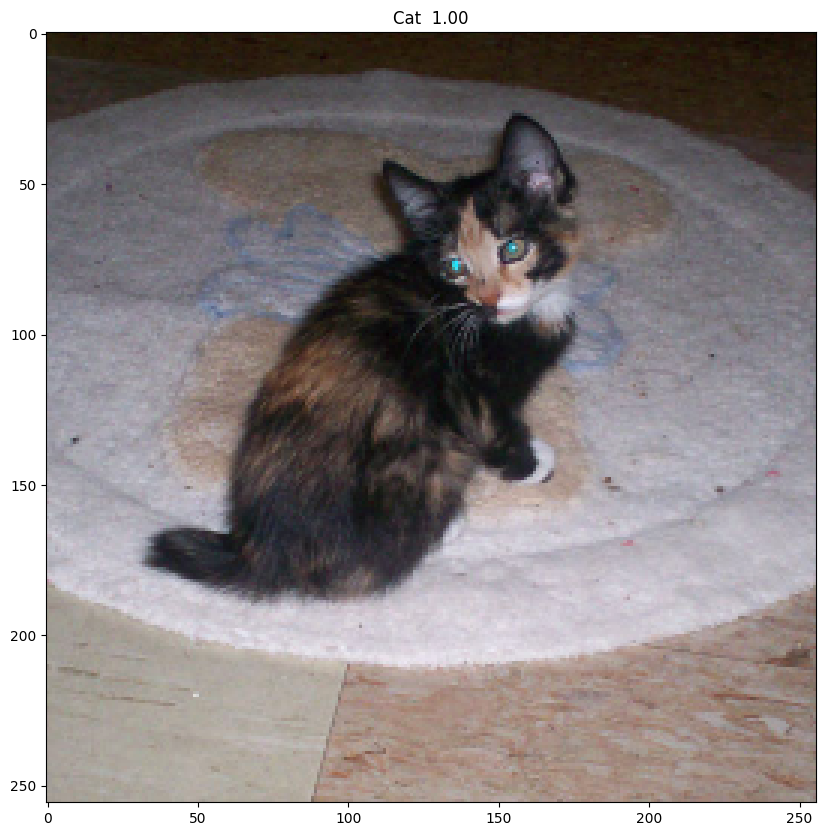

In [9]:
image_filename = 'data/PetImages/Cat/10050.jpg' # 'data/PetImages/Cat/12209.jpg'

img = load_image(image_filename)
pred = model.predict(img)
class_name = 'Cat' if pred[0].argmax()==0 else 'Dog'
propability = pred[0].max()
pyplot.imshow(img[0])
pyplot.title(f'{class_name}  {propability:.2f}')
pyplot.show()

In [10]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 convert_to_inner (Conv2D)      (None, 256, 256, 32  2432        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 256, 256, 32  128        ['convert_to_inner[0][0]']       
 rmalization)                   )                                                           

In [11]:
last_conv_layer = model.get_layer('concentrate_out_E')


model_fm = tf.keras.Model(inputs=model.inputs,
                          outputs=[
                              model.output,
                              last_conv_layer.output
                          ])

In [12]:
model_out, feature_maps = model_fm.predict(img)

# get rid of the batch channel, e.g. (1, 2) -> (2,)
feature_maps = numpy.squeeze(feature_maps)
model_out = numpy.squeeze(model_out)

print(f'Model out shape: {model_out.shape}')        # (2,)
print(f'Model features shape: {feature_maps.shape}')     # (8, 8, 2)

1/1 [==============================] - 0s 184ms/step
Model out shape: (2,)
Model features shape: (4, 4, 2)


In [13]:
weights = numpy.array([1.0, 0.0])
print(weights.shape)
max_idx = numpy.argmax( model_out )
print(f"Max index: {max_idx} ({model_out[max_idx]*100:.2f}%)")

(2,)
Max index: 0 (100.00%)


In [14]:
winning_weights = weights[max_idx]
print(winning_weights.shape) 

CAM = feature_maps.copy()
CAM = CAM[:, :, max_idx]
CAM = CAM/CAM.max()
CAM = (CAM*255).astype(numpy.uint8)

heatmap = cv2.resize(CAM, (img.shape[2], img.shape[1]))
heatmap_img = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
union_img = cv2.addWeighted(heatmap_img, 0.5, (img[0]*255).astype(numpy.uint8), 0.5, 0)

()


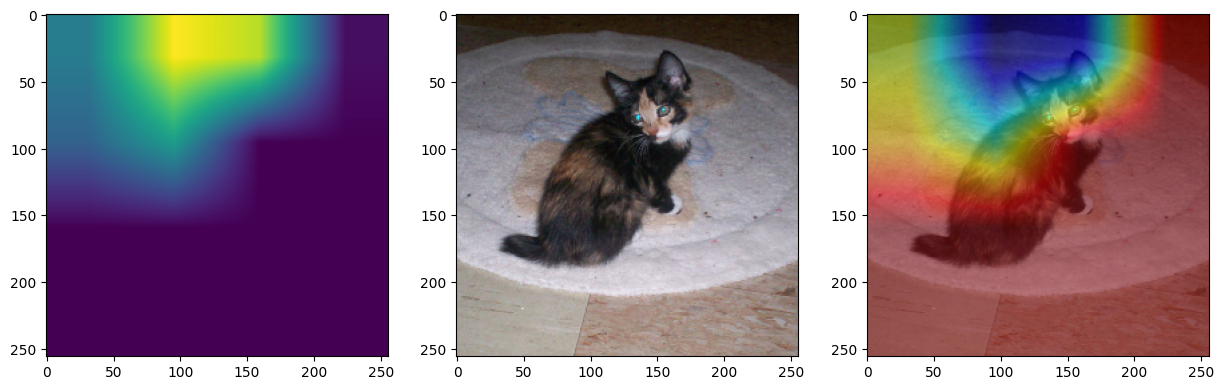

In [15]:
pyplot.subplot(131)
pyplot.imshow(heatmap)
pyplot.subplot(132)
pyplot.imshow(img[0])
pyplot.subplot(133)
pyplot.imshow(union_img) #
pyplot.show()
